# Solving with a Machine Learning Approach

In [1]:
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

boston = load_boston()
X = pd.DataFrame(scale(boston.data), 
                columns = boston.feature_names)
y = boston.target

X_train, X_test, y_train, y_test = train_test_split(X, y,
                            shuffle=True, stratify=X['CHAS']>0,
                            test_size=0.2, random_state=42)

In [2]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [3]:
print(f"train R2: {lm.score(X_train, y_train):0.3}")

train R2: 0.735


## Understanding R Squared

In [4]:
import numpy as np

mean_y = np.mean(y_train)
squared_errors_mean = np.sum((y_train - mean_y)**2)
squared_errors_model = np.sum((y_train -
                           lm.predict(X_train))**2)
R2 = 1 - (squared_errors_model / squared_errors_mean)

print (f"Computed R2:{R2}")

Computed R2:0.7345817245515912


In [5]:
print([feat+':'+str(round(coef, 1)) for feat, coef in 
       zip(boston.feature_names, lm.coef_)])

['CRIM:-0.6', 'ZN:0.9', 'INDUS:0.2', 'CHAS:0.8', 'NOX:-2.1', 'RM:2.7', 'AGE:0.2', 'DIS:-2.9', 'RAD:2.4', 'TAX:-1.8', 'PTRATIO:-2.2', 'B:1.0', 'LSTAT:-4.0']


## Mixing Variables of Different Types

In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

lbl = LabelEncoder()
enc = OneHotEncoder(sparse=False)
qualitative = ['red', 'red', 'green', 'blue', 
               'red', 'blue', 'blue', 'green']
labels = lbl.fit_transform(qualitative).reshape(-1, 1)

print(enc.fit_transform(labels))

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [7]:
print(lbl.classes_)

['blue' 'green' 'red']


In [8]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(degree=2)
poly_X_train = pf.fit_transform(X_train)

lm = LinearRegression()
lm.fit(poly_X_train, y_train)
r2 = lm.score(poly_X_train, y_train)

print(f"train R2: {r2:0.3}")

train R2: 0.934


In [9]:
poly_X_test = pf.transform(X_test)
r2 = lm.score(poly_X_test, y_test)
print(f"test R2: {r2:0.3}")

test R2: 0.787


# Switching to Probabilities

In [10]:
from sklearn.linear_model import LinearRegression
import numpy as np

y = np.array([0, 0, 0, 0, 1, 1, 1, 1])
X = np.array([1, 2, 3, 4, 5, 6, 7, 8]).reshape(8,1)

lm = LinearRegression()
lm.fit(X, y)
preds = lm.predict(X)

for y_true, y_pred in zip(y, preds):
    print(f"{y_true} -> {y_pred:+0.3}")

0 -> -0.167
0 -> +0.0238
0 -> +0.214
0 -> +0.405
1 -> +0.595
1 -> +0.786
1 -> +0.976
1 -> +1.17


In [11]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train>=35)

from sklearn.metrics import accuracy_score
in_sample_acc = accuracy_score(y_train>=35, lr.predict(X_train))
out_sample_acc = accuracy_score(y_test>=35, lr.predict(X_test))

print(f'In-sample accuracy: {in_sample_acc:0.3}')
print(f'Out-of-sample accuracy: {out_sample_acc:0.3}')

In-sample accuracy: 0.963
Out-of-sample accuracy: 0.951


In [12]:
for var, coef in zip(X_train.columns, lr.coef_[0]):
    print(f"{var:7} : {coef:+0.3}")

CRIM    : +0.337
ZN      : -0.0501
INDUS   : -0.196
CHAS    : -0.0514
NOX     : -0.334
RM      : +1.3
AGE     : +0.201
DIS     : -0.682
RAD     : +1.19
TAX     : -0.254
PTRATIO : -0.713
B       : +0.269
LSTAT   : -2.63


In [13]:
print('classes:',lr.classes_)
print('\nProbs:\n',lr.predict_proba(X_test)[:3,:])

classes: [False  True]

Probs:
 [[0.98071307 0.01928693]
 [0.99819753 0.00180247]
 [0.84429169 0.15570831]]


## Defining the outcome of features that don’t work together

In [14]:
r2_train = list()
r2_test = list()

for i in range(1, 129):
    X_train_extra =  np.column_stack((X_train, np.random.rand(len(X_train), i)))
    X_test_extra =  np.column_stack((X_test, np.random.rand(len(X_test), i)))
    
    lr = LinearRegression()
    lr.fit(X_train_extra, y_train)
    
    r2_train.append(lr.score(X_train_extra, y_train))
    r2_test.append(lr.score(X_test_extra, y_test))    

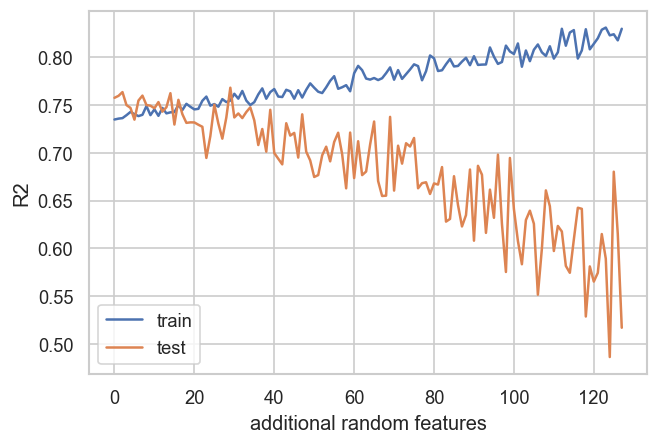

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(dpi=120)
plt.plot(r2_train, label='train')
plt.plot(r2_test, label='test')
plt.xlabel("additional random features")
plt.ylabel("R2")
plt.legend(loc="lower left")
plt.show()

## Solving overfitting by using greedy selection

In [16]:
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(degree=2)
poly_X_train = pf.fit_transform(X_train)
poly_X_test = pf.transform(X_test)

selector = RFECV(estimator=LinearRegression(), step=1, cv=3, scoring='r2')

selector.fit(poly_X_train, y_train)

RFECV(cv=3,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=None, scoring='r2', step=1, verbose=0)

In [17]:
n_features = selector.n_features_
print(f"Features reduced to {n_features} from {poly_X_train.shape[1]}")

Features reduced to 24 from 105


In [18]:
r2_train = selector.score(poly_X_train, y_train)
print(f"R2 train: {r2_train:0.3}")

R2 train: 0.877


In [19]:
r2_test = selector.score(poly_X_test, y_test)
print(f"R2 test: {r2_test:0.3}")

R2 test: 0.826


## Addressing Overfitting by Regularization

In [20]:
from sklearn.linear_model import RidgeCV

l2_lm = RidgeCV(alphas=[0.001, 0.01, 0.1, 1, 10, 100], 
                normalize=True, cv=5, scoring='r2')
l2_lm.fit(X_train, y_train)

best_alpha = l2_lm.alpha_
r2_test = l2_lm.score(X_test, y_test)

print(f"best alpha is: {best_alpha}")
print(f"test R2: {r2_test:0.3}")

best alpha is: 0.1
test R2: 0.753


In [21]:
for var, coef in zip(X_train.columns, l2_lm.coef_):
    print(f"{var:7} : {coef:+0.3}")

CRIM    : -0.438
ZN      : +0.546
INDUS   : -0.247
CHAS    : +0.886
NOX     : -1.32
RM      : +2.79
AGE     : +0.0356
DIS     : -2.09
RAD     : +1.02
TAX     : -0.718
PTRATIO : -1.88
B       : +0.943
LSTAT   : -3.49


In [22]:
from sklearn.linear_model import LassoCV

l1_lm = LassoCV(alphas=[0.001, 0.01, 0.1, 1, 10, 100], 
                normalize=True, cv=5)
l1_lm.fit(X_train, y_train)

best_alpha = l1_lm.alpha_
r2_test = l1_lm.score(X_test, y_test)

print(f"best alpha is: {best_alpha}")
print(f"test R2: {r2_test:0.3}")

best alpha is: 0.001
test R2: 0.756


# Understanding SGD is different

In [23]:
from sklearn.linear_model import SGDRegressor

SGD = SGDRegressor(penalty='l1',
                   learning_rate='invscaling', 
                   eta0=0.01, power_t=0.25)

r2_train = list()
r2_test = list()

for i in range(30):
    for j in range(len(X_train)):    
        SGD.partial_fit(X_train.iloc[[j], :], 
                        y_train[[j]])
        
    r2_train.append(SGD.score(X_train, y_train))
    r2_test.append(SGD.score(X_test, y_test))

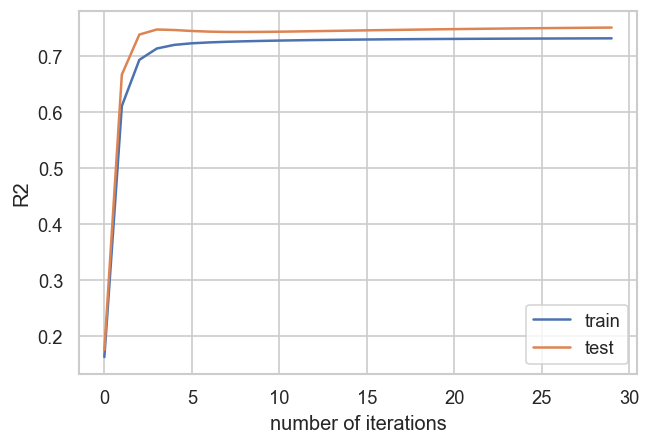

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(dpi=120)
plt.plot(r2_train, label='train')
plt.plot(r2_test, label='test')
plt.xlabel("number of iterations")
plt.ylabel("R2")
plt.legend()
plt.show()